In [2]:
# env = ag , python 3.11.11

In [81]:
import pandas as pd
import numpy as np
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt



# Dataset

## Rossmann Store Sales
Forcaste the sales column. (number of Sales) Regression.


It is not imbalanced but there are only 9 columns. 

In [82]:
train = pd.read_csv("/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Data/rossmann-store-sales/train.csv")
store = pd.read_csv("/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Data/rossmann-store-sales/store.csv")
data = train.merge(store, on='Store', how='inner')
data


/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_49594/1202492203.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Data/rossmann-store-sales/train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [84]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

# Drop columns we don't want
data = data.drop(columns=['Date', 'Customers']) # Customers is correlated with Sales, try both with and without it

## Startified

### Split the data into 5 datasets startified.

The problem with regression is that because it has continues values for the label it is not possible to easily do the startification (like in classification). 
The trick is to first split it into different bins (pandas qcut: Quantile-based discretization function , first 10% of the values, second 10% of the values and so on). Then use those bins for startification. Basically it makes sure to take the same amount of records from each bin. Use Kfold for making the 5 datasets and then train_test_split for splitiing each of those datasets.


In [85]:
y = data["Sales"]
X = data.drop("Sales" , axis = 1)

In [86]:
# Quantile bins for stratification, turn them to categories based on their index. (Kfold needs y to be category)
y_bins = pd.qcut(y, q=10, duplicates='drop')
y_bins = y_bins.cat.codes

In [87]:
# Create 5 stratified subsets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

splits = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_bins)):
    X_subset = X.iloc[test_idx]
    y_subset = y.iloc[test_idx]
    splits.append((X_subset, y_subset))
    print(f"Subset {fold+1}: {X_subset.shape}")

Subset 1: (203442, 19)
Subset 2: (203442, 19)
Subset 3: (203442, 19)
Subset 4: (203442, 19)
Subset 5: (203441, 19)


In [88]:
datasets = []  # Store (X_train, X_test, y_train, y_test) for each subset

for i, (X_sub, y_sub) in enumerate(splits):
    # Re-bin within subset for stratification
    y_bins_sub = pd.qcut(y_sub, q=10, duplicates='drop')
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=0.2, stratify=y_bins_sub, random_state=42
    )
    
    datasets.append((X_train, X_test, y_train, y_test))
    print(f"Subset {i+1}: Train={X_train.shape}, Test={X_test.shape}")

Subset 1: Train=(162753, 19), Test=(40689, 19)
Subset 2: Train=(162753, 19), Test=(40689, 19)
Subset 3: Train=(162753, 19), Test=(40689, 19)
Subset 4: Train=(162753, 19), Test=(40689, 19)
Subset 5: Train=(162752, 19), Test=(40689, 19)


In [89]:
X_train_1, X_test_1, y_train_1, y_test_1 = datasets[0]
X_train_2, X_test_2, y_train_2, y_test_2 = datasets[1]
X_train_3, X_test_3, y_train_3, y_test_3 = datasets[2]
X_train_4, X_test_4, y_train_4, y_test_4 = datasets[3]
X_train_5, X_test_5, y_train_5, y_test_5 = datasets[4]
# Use the fifth one as the new data for testing

In [90]:
X_main_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4 , X_train_5 ]).reset_index(drop=True)
y_main_train = pd.concat([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5 ]).reset_index(drop=True)
X_main_test = pd.concat([X_test_1, X_test_2, X_test_3, X_test_4 , X_test_5]).reset_index(drop=True)
y_main_test = pd.concat([y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]).reset_index(drop=True)

In [91]:
main_train_df = X_main_train.copy()
main_train_df['Sales'] = y_main_train
main_train_df

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,Sales
0,44,2,1,1,0,0,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN,2014,5,6,19,7076
1,346,2,1,1,0,1,a,c,8090.0,NaN,NaN,0,NaN,NaN,NaN,2014,7,29,31,8129
2,331,7,0,0,0,0,a,c,670.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct",2014,9,28,39,0
3,572,7,0,0,0,0,d,c,9230.0,4.0,2004.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",2013,11,17,46,0
4,1014,3,1,1,0,1,a,c,210.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,7,15,29,12288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813759,932,6,1,0,0,0,a,a,15700.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2013,10,5,40,4994
813760,25,2,1,0,0,0,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN,2013,5,7,19,13145
813761,135,2,1,1,0,1,d,a,5190.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct",2015,3,31,14,9776
813762,923,4,1,0,0,0,a,a,280.0,9.0,2008.0,0,NaN,NaN,NaN,2015,3,12,11,4790


In [92]:
main_test_df = X_main_test.copy()
main_test_df['Sales'] = y_main_test
main_test_df

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,Sales
0,448,5,1,0,0,0,a,c,3970.0,9.0,2009.0,0,NaN,NaN,NaN,2014,9,26,39,7418
1,1113,2,1,0,0,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,7,9,28,5258
2,408,7,0,0,0,0,c,a,1560.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",2013,2,10,6,0
3,410,1,1,1,0,0,c,a,40.0,11.0,2011.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2014,2,3,6,11920
4,193,1,1,0,0,0,a,a,520.0,NaN,NaN,0,NaN,NaN,NaN,2013,11,11,46,4371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203440,282,4,1,1,0,0,a,a,1220.0,12.0,2010.0,0,NaN,NaN,NaN,2013,8,15,33,5525
203441,1111,2,1,1,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2014,11,25,48,6679
203442,531,2,1,1,0,0,a,c,4030.0,NaN,NaN,0,NaN,NaN,NaN,2015,1,27,5,6042
203443,904,7,0,0,0,0,d,c,570.0,7.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,2,22,8,0


In [ ]:
'''
Trained for more than 120 min
label = 'Sales'
predictor= TabularPredictor(label=label, path="AutogluonModels/" ).fit(main_train_df,  presets="best")
'''

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.71 GB / 8.00 GB (21.4%)
Disk Space Avail:   59.06 GB / 228.27 GB (25.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to i

KeyboardInterrupt: 

In [16]:
# predictor = TabularPredictor.load("AutogluonModels/")

In [17]:
# predictor.leaderboard(silent=True)

### Evaluation Metrics

| Metric                                | Ideal Direction        | Meaning                                                                                                                                          |
| ------------------------------------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **RMSE (Root Mean Squared Error)**    | ↓ lower = better       | Measures the *typical deviation* between predicted and actual values, penalizing large errors strongly. Same unit as the target (here: “Sales”). |
| **MAE (Mean Absolute Error)**         | ↓ lower = better       | Measures the *average absolute difference* between prediction and truth. More robust to outliers than RMSE.                                      |
| **R² (Coefficient of Determination)** | ↑ closer to 1 = better | Measures how much of the variance in your target is explained by the model (1 = perfect fit, 0 = no better than predicting the mean).            |
| **Pearson r**                         | ↑ closer to 1 = better | Measures *linear correlation* between predicted and true values. Often very close to √R² for linear relationships.                               |


In [18]:
# Evaluate on all the test data takes about 16 min
# The negative values are because AutoGluon uses the same logic for regression and classification and in classification bigger is better, 
# but in regression RMSE and the errors smaller is better therefore it uses negative to sustain the logic. But we know in reality errors are like distance and are always positive.
# RMSE(Root Mean Squared Error): Off by ~524 sales units on average. Compare it to the scale of the target variable. -> Good
# MAE: Average absolute deviation — usually smaller than RMSE (good).
# R²: Excellent! Model explains about 95% of the variation in sales.
# Pearson r: Very strong correlation between predicted and true values.

# performance_main = predictor.evaluate(main_test_df)
# performance_main

In [19]:
# To find out whether the values of the prediction are good or not, we can compare them with the scale of true labels. 
# We see that mean is 5774 and the model is only off by ‍around 525 units (less than 10%) therefore the results are really good.

# main_test_df["Sales"].describe()

In [20]:
# preds_1 = predictor.predict(X_test_1)
# preds_1

In [21]:
# df_1 = X_test_1 
# df_1["Sales"] = y_test_1
# eval_1 = predictor.evaluate(df_1)
# eval_1

In [22]:
'''
plt.scatter(y_test_1, preds_1, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()
'''

'\nplt.scatter(y_test_1, preds_1, alpha=0.5)\nplt.xlabel("Actual Sales")\nplt.ylabel("Predicted Sales")\nplt.title("Predicted vs Actual Sales")\nplt.show()\n'

In [23]:
'''
df_2 = X_test_2
df_2["Sales"] = y_test_2
small_df = df_2[1000:1100]
small_df

'''

'\ndf_2 = X_test_2\ndf_2["Sales"] = y_test_2\nsmall_df = df_2[1000:1100]\nsmall_df\n\n'

In [24]:
# eval_small = predictor.evaluate(small_df)
# eval_small

In [25]:
# small_df["Sales"].describe()

In [94]:
'''
#Trained for 5 min
# I had to disable the stacking that AutoGluon does for best quality due to the time limit.
label = 'Sales'
predictor_5min= TabularPredictor(label=label, path="AutogluonModels_5min/" ).fit(main_train_df,  presets="best" , time_limit = 300 , dynamic_stacking=False)
'''


Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.29 GB / 8.00 GB (16.1%)
Disk Space Avail:   58.91 GB / 228.27 GB (25.8%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min"
Train Data Rows:    813764
Train Data Columns: 19
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int

In [97]:
predictor_5min = TabularPredictor.load("AutogluonModels_5min/")

In [98]:
predictor_5min.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-1228.901638,root_mean_squared_error,34.428018,712.119100,34.428018,712.119100,1,True,1
1,WeightedEnsemble_L2,-1228.901638,root_mean_squared_error,34.438751,712.131211,0.010733,0.012111,2,True,2
2,WeightedEnsemble_L3,-1228.901638,root_mean_squared_error,34.443994,712.129465,0.015976,0.010365,3,True,3


In [99]:
predictor_5min.evaluate(main_test_df)

{'root_mean_squared_error': np.float64(-1220.2586419696622),
 'mean_squared_error': -1489031.25,
 'mean_absolute_error': -817.1175537109375,
 'r2': 0.8994207978248596,
 'pearsonr': 0.9497280605818037,
 'median_absolute_error': -538.45556640625}

In [106]:
small_df = main_test_df.sample(frac=0.001, random_state=42)
big_df = main_test_df.sample(frac=0.2, random_state=42)

In [107]:
eval_small_df_5min = predictor_5min.evaluate(small_df)
eval_small_df_5min

{'root_mean_squared_error': np.float64(-1216.6799538602845),
 'mean_squared_error': -1480310.25,
 'mean_absolute_error': -867.4387817382812,
 'r2': 0.8894976377487183,
 'pearsonr': 0.9440263458644795,
 'median_absolute_error': -607.257568359375}

In [102]:
eval_big_df_5min = predictor_5min.evaluate(big_df)
eval_big_df_5min

{'root_mean_squared_error': np.float64(-1224.7126015860536),
 'mean_squared_error': -1499921.0,
 'mean_absolute_error': -820.2205200195312,
 'r2': 0.8997418284416199,
 'pearsonr': 0.9498712659272299,
 'median_absolute_error': -533.76025390625}

In [108]:
small_df["Sales"].describe()

count      203.000000
mean      5720.729064
std       3669.127847
min          0.000000
25%       3809.500000
50%       5557.000000
75%       7874.500000
max      20422.000000
Name: Sales, dtype: float64

In [105]:
big_df["Sales"].describe()

count    40689.000000
mean      5765.284082
std       3867.939275
min          0.000000
25%       3713.000000
50%       5734.000000
75%       7846.000000
max      38722.000000
Name: Sales, dtype: float64

In [109]:
small_df_label = small_df["Sales"]
small_df.drop("Sales" , axis = 1)
pred_small_5min = predictor_5min.predict(small_df)
pred_small_5min

138619    7137.845703
39765     6031.395996
173119    6781.165039
53208      114.660522
142984    -415.410583
             ...     
154286    4398.961914
184941    3868.238037
27894      -49.772305
156614    4397.805664
9469      6237.773926
Name: Sales, Length: 203, dtype: float32

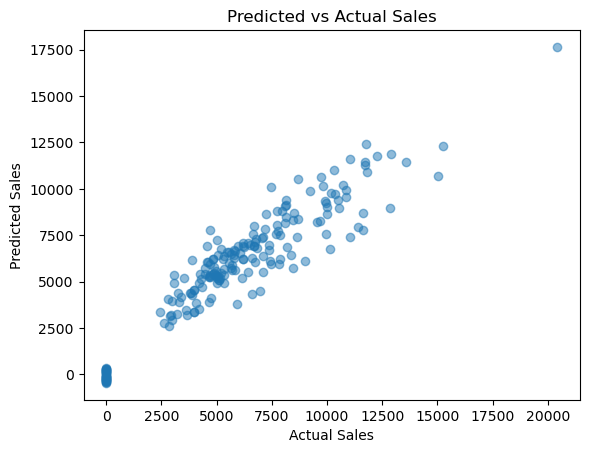

In [110]:
plt.scatter(small_df_label, pred_small_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [111]:
big_df_label = big_df["Sales"]
big_df.drop("Sales" , axis = 1)
pred_big_5min = predictor_5min.predict(big_df)
pred_big_5min

138619     7137.845703
39765      6031.395996
173119     6781.165039
53208       114.660522
142984     -415.410583
              ...     
23544      9241.025391
123598     6699.707031
113608      105.394547
111861    11900.609375
140261     4743.602539
Name: Sales, Length: 40689, dtype: float32

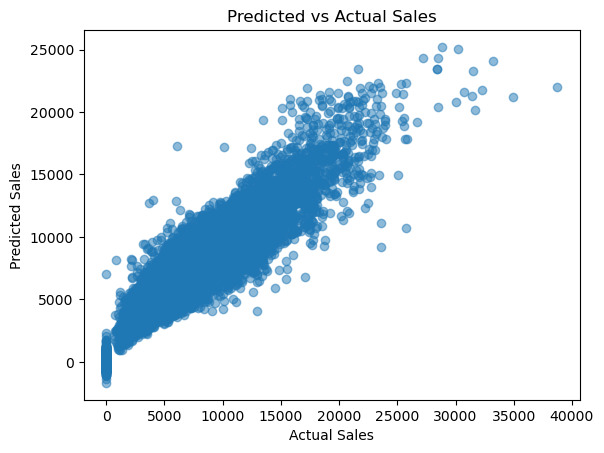

In [112]:
plt.scatter(big_df_label, pred_big_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [37]:
# The results still seem to be good!!!
# But it is worse than before
# It seems like the 5 min trained model is performing worse in the small dataset comparing to the big dataset. Or maybe not. Analyze properly.

## Non-Startified

In [8]:
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [9]:
n_splits = 5

split_size = len(data) // n_splits

data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

datasets = []
for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(data_shuffled)
    datasets.append(data_shuffled.iloc[start_idx:end_idx].reset_index(drop=True))

In [10]:
datasets[0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,616,7,2015-05-24,0,0,0,0,0,0
1,592,2,2013-03-26,5548,710,1,1,0,1
2,526,6,2013-09-14,7467,1150,1,0,0,0
3,601,2,2013-07-23,3360,323,1,0,0,1
4,953,1,2014-12-15,11414,853,1,1,0,0
...,...,...,...,...,...,...,...,...,...
203436,430,3,2015-05-13,10632,883,1,0,0,0
203437,370,6,2014-02-01,8822,715,1,0,0,0
203438,199,1,2013-08-26,11716,833,1,1,0,0
203439,1069,6,2015-06-27,3375,406,1,0,0,0


In [11]:
splits = {}

for i, ds in enumerate(datasets):
    train, test = train_test_split(ds, test_size=0.2, random_state=42)  
    splits[f'dataset_{i+1}'] = {'train': train.reset_index(drop=True),
                                 'test': test.reset_index(drop=True)}

In [12]:
X_train_1, X_test_1 = splits['dataset_1']['train'] , splits['dataset_1']['test'] 
X_train_2, X_test_2 = splits['dataset_2']['train'] , splits['dataset_2']['test'] 
X_train_3, X_test_3= splits['dataset_3']['train'] , splits['dataset_3']['test'] 
X_train_4, X_test_4= splits['dataset_4']['train'] , splits['dataset_4']['test'] 
X_train_5, X_test_5= splits['dataset_5']['train'] , splits['dataset_5']['test'] 

In [13]:
X_main_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4 , X_train_5]).reset_index(drop=True)
X_main_test = pd.concat([X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]).reset_index(drop=True)

In [14]:
label = 'Sales'
predictor_5min_non= TabularPredictor(label=label, path="AutogluonModels_5min_non/" ).fit(X_main_train,  presets="best" , time_limit = 300 , dynamic_stacking=False)

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       2.36 GB / 8.00 GB (29.5%)
Disk Space Avail:   60.86 GB / 228.27 GB (26.7%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min_non"
Train Data Rows:    813764
Train Data Columns: 8
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == 

In [15]:
preds = predictor_5min_non.evaluate(X_main_test)
preds

{'root_mean_squared_error': np.float64(-1186.1352098556183),
 'mean_squared_error': -1406916.75,
 'mean_absolute_error': -799.6596069335938,
 'r2': 0.9043084383010864,
 'pearsonr': 0.9509626837572209,
 'median_absolute_error': -579.4013671875}

In [16]:
X_main_test["Sales"].describe()

count    203445.000000
mean       5770.776102
std        3834.409019
min           0.000000
25%        3733.000000
50%        5745.000000
75%        7854.000000
max       38722.000000
Name: Sales, dtype: float64

In [21]:
small_df = pd.concat([X_test_1[100:150] ,X_test_2[100:150] ,X_test_3[100:150] ,X_test_4[100:150] , X_test_5[100:150]])
preds_small_df = predictor_5min_non.evaluate(small_df)
preds_small_df

{'root_mean_squared_error': np.float64(-1266.757721314965),
 'mean_squared_error': -1604675.125,
 'mean_absolute_error': -875.7783813476562,
 'r2': 0.8728040456771851,
 'pearsonr': 0.934317945327943,
 'median_absolute_error': -663.110107421875}

In [19]:
small_df["Sales"].describe()

count      250.000000
mean      5837.884000
std       3558.993573
min          0.000000
25%       3837.000000
50%       5841.000000
75%       7900.250000
max      19314.000000
Name: Sales, dtype: float64